## Importing + Reading in Data

In [82]:
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [39]:
# reading in CSVs
meta_data = pd.read_csv("Data\\Nashvillemeetup\\meta-groups.csv")
group_edges = pd.read_csv("Data\\Nashvillemeetup\\group-edges.csv", index_col=0)
member_to_group = pd.read_csv("Data\\Nashvillemeetup\\member-to-group-edges.csv")
member_edges = pd.read_csv("Data\\Nashvillemeetup\\member-edges.csv")
meta_events = pd.read_csv("Data\\Nashvillemeetup\\meta-events.csv")
rsvps = pd.read_csv("Data\\Nashvillemeetup\\rsvps.csv", index_col=0)

In [40]:
# from csv to graph
g_group_group = nx.from_pandas_edgelist(group_edges, "group1", "group2", edge_attr="weight")
g_member_group = nx.from_pandas_edgelist(member_to_group, "member_id", "group_id", edge_attr="weight")

## Feature Engineering and EDA

### Normamlized shared members

It makes sense to normalize the number of shared members by the number of people in the respective group. If 2 groups have 1000 members each and share only one, their connection is much weaker than 2 groups with 10 members each that share 1.

In [41]:
merge_grp1 = group_edges.merge(meta_data[["num_members", "group_id"]], left_on="group1", right_on="group_id")
merge_grp2 = merge_grp1.merge(meta_data[["num_members", "group_id"]], left_on="group2", right_on="group_id", suffixes=("_1", "_2"))
merged_both = merge_grp2.drop(columns=["group_id_1", "group_id_2"])

merged_both["rel_shared"] = merged_both["weight"] / merged_both[["num_members_1", "num_members_2"]].min(axis=1)

In [42]:
merged_both.head(3)

,group1,group2,weight,num_members_1,num_members_2,rel_shared
0,19292162,535553,2,237,881,0.008439
1,19275797,535553,1,256,881,0.003906
2,1179719,535553,1,965,881,0.001135


### Degree Distribution

<AxesSubplot:xlabel='Degree', ylabel='Count'>

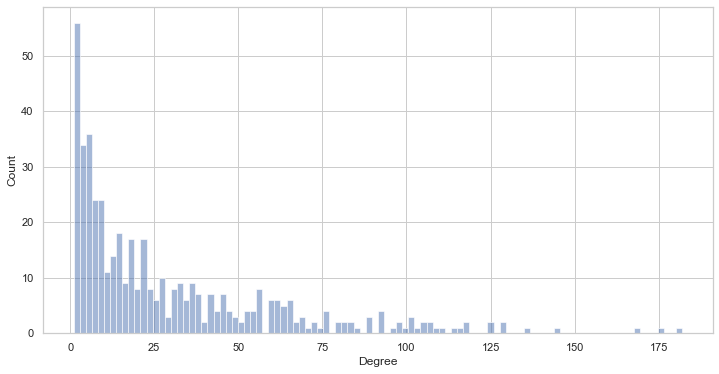

In [43]:
fig, ax = plt.subplots(figsize=(12,6))
fig.patch.set_facecolor("white")
ax.set_xlabel("Degree")
sns.histplot(dict(g_group_group.degree()).values(), bins=100, ax=ax, legend=None)

We can see a fat tailed distribution of the degrees.

### Adding attributes to our meta group data

In [44]:
# calculate clustering and degree for every group
clustering = pd.Series(nx.algorithms.clustering(g_group_group).values())
degree = pd.Series(dict(g_group_group.degree()).values())

# join clustering and degree together
metrics = pd.concat([clustering, degree], axis=1).rename(columns={0:"Clustering", 1:"Degree"})
metrics.set_index(pd.Series(dict(g_group_group.degree()).keys()), inplace=True)

# merge the graph info with the rest of the metadata
metrics = metrics.merge(meta_data, left_index=True, right_on="group_id")

### Ploting the group to group graph

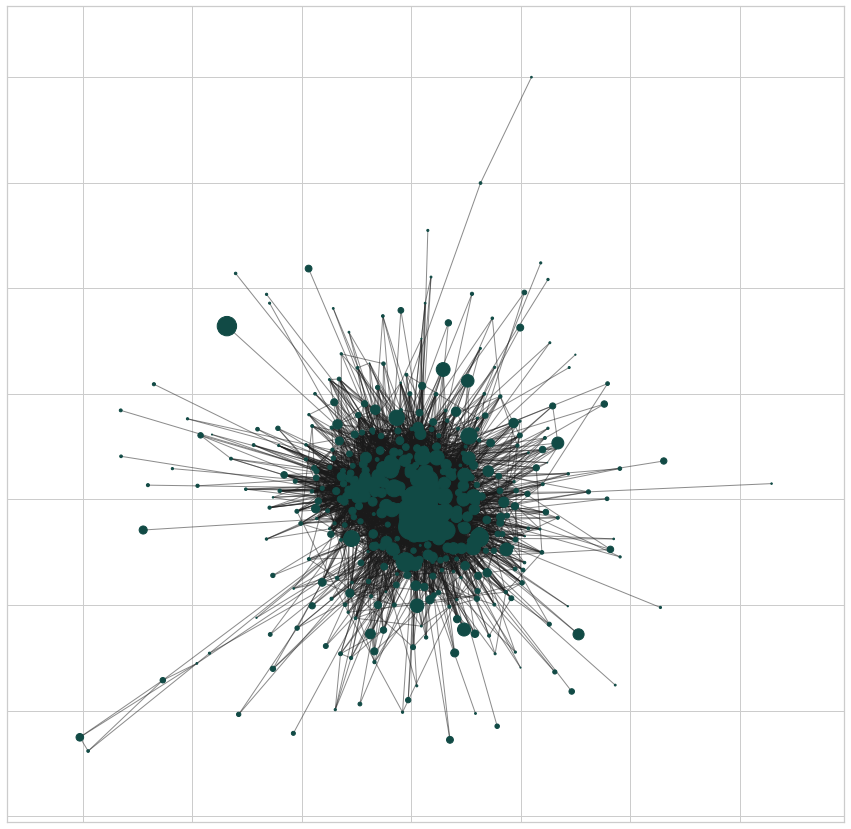

In [45]:
fig, ax = plt.subplots(figsize=(15,15))
pos = nx.spring_layout(g_group_group)
nx.draw_networkx_nodes(g_group_group, pos=pos, node_size=metrics["num_members"]/10, ax=ax, nodelist=g_group_group.nodes(), node_color="#114a45")
nx.draw_networkx_edges(g_group_group, pos=pos, ax=ax, nodelist=g_group_group.nodes(), alpha=0.5, edge_vmin=0.5)

Although the visualization is quite messy we can see that some of the nodes have a lot of members while not being connected to many other groups. This is what we could call "self-contained" groups as the members who are active in that groups are not active in many other groups. Also, groups that have no shared members do not show up in the graph.
We will try to define metrics for identifying these "self-contained" groups later on.

### Ranking categories by number of Members

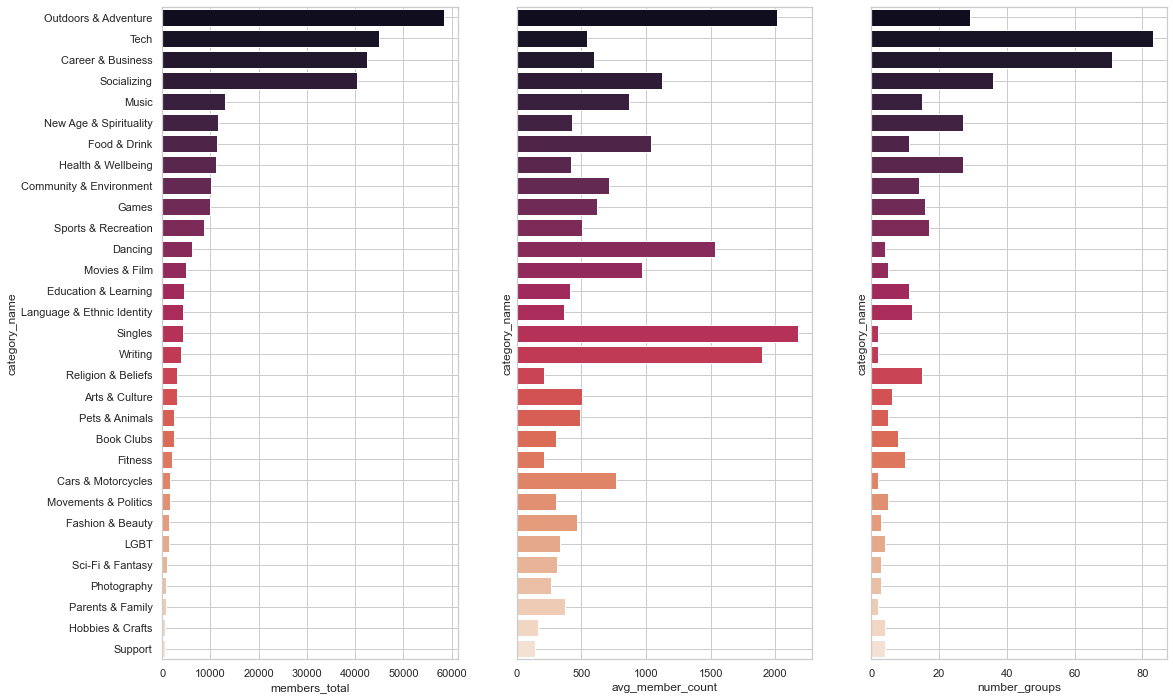

In [46]:
# aggregate the data that we need.
ordered = metrics.groupby(["category_name"]).agg(members_total = ("num_members","sum"), 
                                                avg_clustering=("Clustering", np.average),
                                                avg_member_count = ("num_members", np.average),
                                                number_groups=("group_id", "count")).sort_values(by="members_total", ascending=False)

# instantiate the figure
fig, ax = plt.subplots(1, 3, figsize=(18, 12), sharey=True)
fig.patch.set_facecolor("white")

    
# plot on the axes and show grids
for j, i in enumerate(["members_total", "avg_member_count", "number_groups"]):
    sns.barplot(y=ordered.index, x=i, data=ordered, palette="rocket",ax=ax[j])
    ax[j].grid(visible=True)
    ax[j].set_axisbelow(True)

As we can see, the 4 main categories are Outdoors & Adventure, Tech, Career & Business and Socializing. These have 2-3 times more members than the next biggest category, Music. The questions is, to these categories have overporoportionally large groups or just many groups? Also, some groups such as Singles and Writing have very few, groups with a lof of members.

### Group Activity

In the member to group graph, the weight indicates how many events a person has been part of in that group. When we aggregate over the different groups, and take the average weight, we can see how many events people have attended with said group on average.

<AxesSubplot:ylabel='Count'>

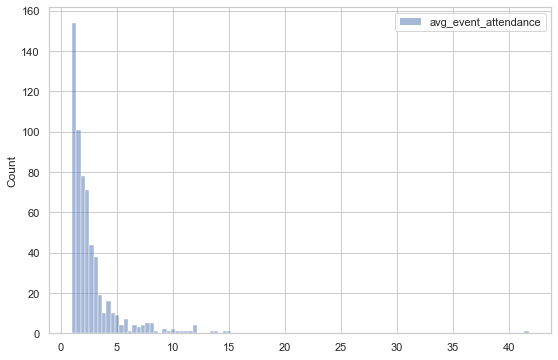

In [47]:
fig, ax = plt.subplots(figsize=(9, 6))
fig.patch.set_facecolor("white")
group_attendance = member_to_group.groupby(["group_id"]).agg(avg_event_attendance=("weight", np.average))
sns.histplot(group_attendance, ax=ax)

Most group members have attended between 1-5 events in a group although there are some very active groups where members have attended more than 5 events on average. Let's look at those specific groups and under which categories they fall.

In [48]:
group_attendance = group_attendance.merge(meta_data[["category_name", "group_id"]], left_index=True, right_on="group_id")

In [49]:
attendance_agg = group_attendance.groupby(["category_name"]).agg(avg_category_attendance=("avg_event_attendance", np.average), attendance_std=("avg_event_attendance", np.std))

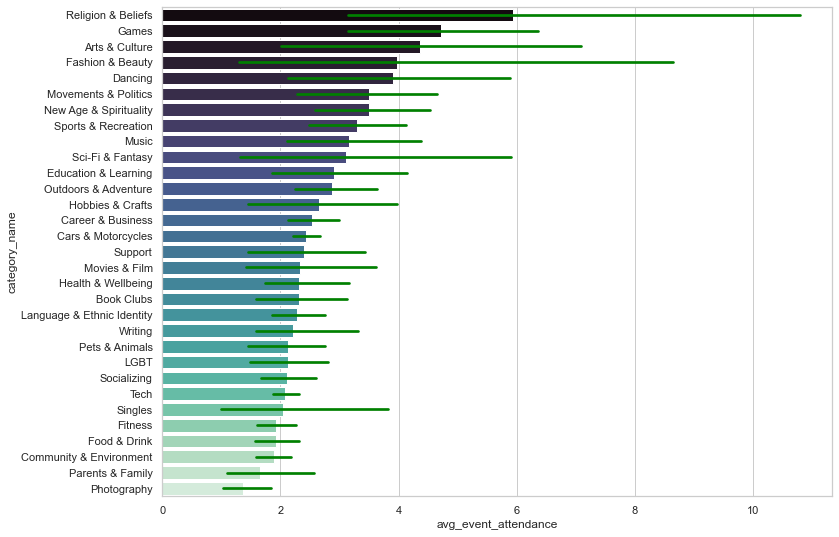

In [50]:
fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_facecolor("white")

sns.set_theme(style="whitegrid")
ax = sns.barplot(x="avg_event_attendance", y="category_name", 
                 data=group_attendance,
                 palette="mako",
                 order=attendance_agg.sort_values(by="avg_category_attendance", ascending=False).index,
                 errcolor="green")

Although there are some differences between categories, we can see from the error bars that the variances are pretty high, making judgements difficualt.

### Time Series of Events

In [51]:
meta_events["monthly"] = pd.to_datetime(meta_events["time"]).dt.strftime("%Y-%m")

<AxesSubplot:xlabel='Time', ylabel='Number of Events'>

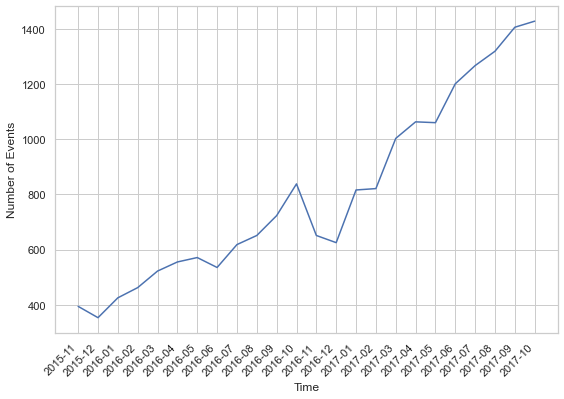

In [52]:
fig, ax = plt.subplots(figsize=(9, 6))
fig.patch.set_facecolor("white")

time_series = meta_events.groupby(["monthly"]).agg(total_events=("event_id","count"))
plt.xticks(rotation=45, ha='right')
plt.grid(visible=True, which="major", axis="x", ls="-")
plt.xlabel("Time")
plt.ylabel("Number of Events")
sns.lineplot(data=time_series, x=time_series.index, y="total_events", ax=ax)

The number of events has been rising steadily, probably due to the rising popularity of the platform.

### Adding information about Groups

#### Add Date Created, Last Event and Number of Events

In the following we want to provide more information about the characteristics of a given group with the goal of clustering them into different types

In [53]:
meta_events["time"] = pd.to_datetime(meta_events["time"])

event_info = meta_events.groupby(["group_id"]).agg(created=("time","min"), time_last_event=("time", "max"), no_events=("event_id", "count"))

In [54]:
metrics= metrics.merge(event_info, left_on="group_id", right_index=True)

<AxesSubplot:xlabel='no_events', ylabel='Count'>

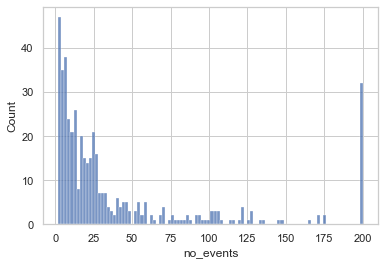

In [55]:
sns.histplot(metrics["no_events"], bins=100)

From the distribution plot we can assume that there is a maximal number of events a given group can host or that after 200 events, no more data is being collected.

#### Regularity of events

- How far apart are events on average?
- What is the standard deviation for the time between events? A high sd would indicate that events do not happen on a regular basis.

In [56]:
meta_events["time"] = pd.to_datetime(meta_events["time"])

In [57]:
regularity_data = meta_events.groupby(["group_id"]).agg(avg_time_diff = ("time", lambda x: x.sort_values().diff().mean()), 
                                      time_diff_std =("time", lambda x: x.sort_values().diff().std()))

In [58]:
metrics_final = metrics.merge(regularity_data, left_on="group_id", right_index=True)

In [59]:
metrics_final["uptime"] = (metrics_final["time_last_event"] - metrics_final["created"]).dt.days

In [60]:
metrics_final.head(3)

,Clustering,Degree,group_id,group_name,num_members,category_id,category_name,organizer_id,group_urlname,created,time_last_event,no_events,avg_time_diff,time_diff_std,uptime
89,0.692192,37,19292162,Nashville CocoaHeads,237,34,Tech,145632652,Nashville-CocoaHeads,2016-01-28,2017-10-25 23:00:00,23,28 days 22:51:49.090909091,17 days 04:01:06.279568134,636
62,0.559615,65,535553,Nash.rb,881,34,Tech,14344641,nashrb,2015-12-15,2017-10-21 13:00:00,23,30 days 18:02:43.636363636,11 days 16:55:08.790177811,676
481,0.561616,55,19194894,Nashville Christian Technologists and Entrepre...,613,34,Tech,193181718,Nashville-Christian-Technologists-and-Entrepre...,2016-01-29,2017-06-29 23:00:00,13,43 days 03:55:00,21 days 11:30:36.874688760,517


<AxesSubplot:xlabel='avg_time_diff', ylabel='Count'>

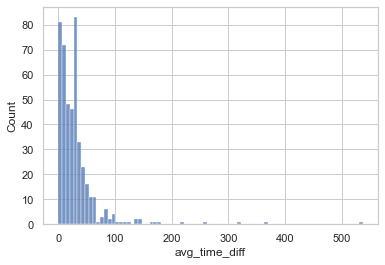

In [61]:
sns.histplot(metrics_final["avg_time_diff"].dt.days)

<AxesSubplot:xlabel='no_events', ylabel='uptime'>

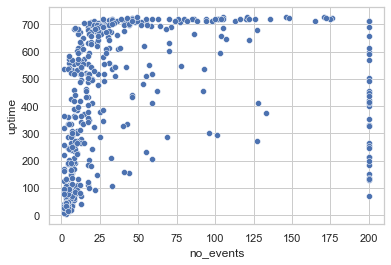

In [62]:
sns.scatterplot(data=metrics_final, x="no_events", y="uptime")

It is hard to analyze the groups with no_events >= 200 because we have to assume that they have had more events in reality. A clear correlation could mean that the groups are quite homogenous, and that they schedule regular events, however, this is not the case. For example, group that have existed for the entire recorded period (around 700 days) do not neccessarily have a high number of events.

## Clustering Groups

### Preparation

In [63]:
cluster_data = metrics_final.copy()
cluster_data.head(3)

,Clustering,Degree,group_id,group_name,num_members,category_id,category_name,organizer_id,group_urlname,created,time_last_event,no_events,avg_time_diff,time_diff_std,uptime
89,0.692192,37,19292162,Nashville CocoaHeads,237,34,Tech,145632652,Nashville-CocoaHeads,2016-01-28,2017-10-25 23:00:00,23,28 days 22:51:49.090909091,17 days 04:01:06.279568134,636
62,0.559615,65,535553,Nash.rb,881,34,Tech,14344641,nashrb,2015-12-15,2017-10-21 13:00:00,23,30 days 18:02:43.636363636,11 days 16:55:08.790177811,676
481,0.561616,55,19194894,Nashville Christian Technologists and Entrepre...,613,34,Tech,193181718,Nashville-Christian-Technologists-and-Entrepre...,2016-01-29,2017-06-29 23:00:00,13,43 days 03:55:00,21 days 11:30:36.874688760,517


In [64]:
# will convert to days so that we can use them in our Clustering Algorithm
cluster_data["avg_time_diff"] = cluster_data["avg_time_diff"].dt.days
cluster_data["time_diff_std"] = cluster_data["time_diff_std"].dt.days

In [65]:
cluster_data["time_diff_std"] = cluster_data["time_diff_std"].fillna(cluster_data["time_diff_std"].mean())

In [66]:
# we will set the most recent event as the current point in time from which we will "calculate backwards"
present = max(cluster_data["time_last_event"])

# convert the date created and the time of the last event to a timestamp
cluster_data["created"] = (present - cluster_data["created"]).dt.days
cluster_data["time_last_event"] = (present - cluster_data["time_last_event"]).dt.days

In [67]:
cluster_data.head(3)

,Clustering,Degree,group_id,group_name,num_members,category_id,category_name,organizer_id,group_urlname,created,time_last_event,no_events,avg_time_diff,time_diff_std,uptime
89,0.692192,37,19292162,Nashville CocoaHeads,237,34,Tech,145632652,Nashville-CocoaHeads,641,5,23,28,17.0,636
62,0.559615,65,535553,Nash.rb,881,34,Tech,14344641,nashrb,685,9,23,30,11.0,676
481,0.561616,55,19194894,Nashville Christian Technologists and Entrepre...,613,34,Tech,193181718,Nashville-Christian-Technologists-and-Entrepre...,640,123,13,43,21.0,517


In [68]:
# dropping non-numerical columns
cluster_final = cluster_data.drop(columns=["group_id", "group_urlname", "group_name", "category_name", "category_id", "organizer_id"])

In [69]:
cluster_final.dtypes

Clustering         float64
Degree               int64
num_members          int64
created              int64
time_last_event      int64
no_events            int64
avg_time_diff        int64
time_diff_std      float64
uptime               int64
dtype: object

### Kmeans Clustering

#### Modelling

In [108]:
scaler = StandardScaler()

n_clusters = range(2,15)

transformed = pd.DataFrame(scaler.fit_transform(cluster_final), columns=cluster_final.columns)

for i in n_clusters:
    clusterer = KMeans(i)
    labels = clusterer.fit_predict(transformed)
    silhouette_avg = silhouette_score(transformed, labels)
    print(f"Number of Clusters:{i}, Silhouette Score: {silhouette_avg}")

Number of Clusters:2, Silhouette Score: 0.2586899297685434
Number of Clusters:3, Silhouette Score: 0.2941406373241344
Number of Clusters:4, Silhouette Score: 0.3111079129572011
Number of Clusters:5, Silhouette Score: 0.3348830375049425
Number of Clusters:6, Silhouette Score: 0.32107300811676015
Number of Clusters:7, Silhouette Score: 0.27741810693922914
Number of Clusters:8, Silhouette Score: 0.2890806984056861
Number of Clusters:9, Silhouette Score: 0.2621109722368206
Number of Clusters:10, Silhouette Score: 0.2577123297235984
Number of Clusters:11, Silhouette Score: 0.2728975960023351
Number of Clusters:12, Silhouette Score: 0.2527541505187774
Number of Clusters:13, Silhouette Score: 0.2520056804125692
Number of Clusters:14, Silhouette Score: 0.2478879490972278


Since we do not have any ground truth labels we will use the silhouette score that describes how well our clustering has been by looking at the distance between the datapoint and its own cluster vs the distance between the datapoint and the other cluster(s). We can see that generally, the clustering is pretty bad, regardless of the number of clusters, although a clustering from 4-6 seems to do best. For simplicity, we will look at analyzing the clustering for 2 groups.

In [84]:
def kmeans_cluster(data, n_comps):
    label = pd.DataFrame(KMeans(n_comps).fit_predict(data), columns=["cluster"])
    results = pd.concat([data.reset_index(), label], axis=1).drop(columns=["index"])
    return results

In [85]:
results = kmeans_cluster(cluster_final, 2)

#### Analyzing Results

In [120]:
results.head(3)

,Clustering,Degree,num_members,created,time_last_event,no_events,avg_time_diff,time_diff_std,uptime,cluster
0,0.692192,37,237,641,5,23,28,17.0,636,0
1,0.559615,65,881,685,9,23,30,11.0,676,0
2,0.561616,55,613,640,123,13,43,21.0,517,0


<AxesSubplot:>

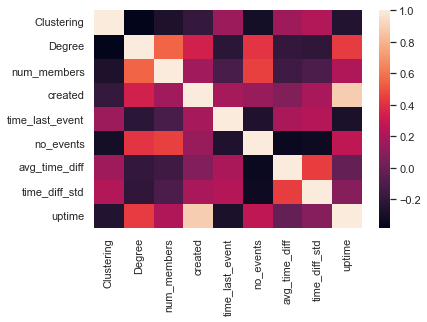

In [74]:
sns.heatmap(results.drop(columns=["cluster"]).corr())

Some of these correlations are very intuitive and logical such as created and uptime where a large discrepancy could only be achieved if the group was created and then didn't host any more events.
Also, number of events and Degree is very intuitive since we defined the degree as the number of connections the group has with other groups, here, we could also think of some qualitative measure to implement or some normalization that could serve as a better metric.

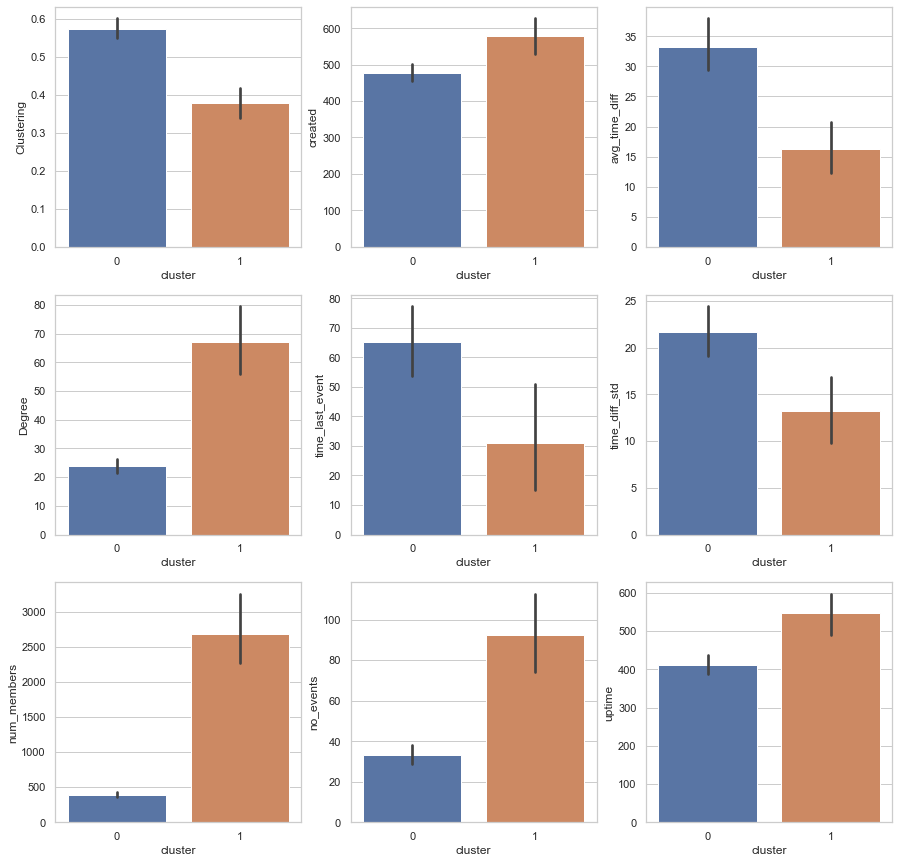

In [75]:
fig, axs = plt.subplots(3,3, figsize=(15,15))

# get the columns we are interested in
cols = results.columns[:-1]
col_count = 0

for i in range(3):
    for j in range(3):
        sns.barplot(data=results, x="cluster", y=cols[col_count], ax=axs[j][i])
        col_count += 1

This clustering is by no means perfect, the fact that a lot of these variables naturally correlate (e.g., num_memebers, no_events and degree) makes it clear that through more feature engineering we could get an even better clustering. There are of course no limits to the types of features one can extract from the data.

Generally speaking, cluster one seems to contain more "matured" groups that 
- exist longer
- have more members
- have more events
- have a lower time between events
- have more regular events

### Plotting Results by using t-SNE

the t-distributed Stochastic Neighborhood Embeding (t-SNE) is a technique to project high dimensional data into a lower dimension in which we can plot the data.

In [104]:
tsne = TSNE(n_components=2)
tsne_transformed = tsne.fit_transform(transformed)

C:\Users\lbmm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\lbmm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


C:\Users\lbmm\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\lbmm\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


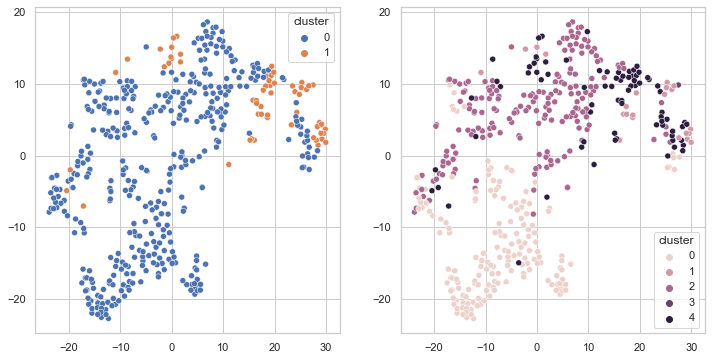

In [119]:
fig, axs = plt.subplots(1,2, figsize=(12,6))
for i, v in enumerate([2,5]):
    cluster_data = kmeans_cluster(cluster_final,v)["cluster"]
    sns.scatterplot(tsne_transformed[:,0], tsne_transformed[:,1], hue=cluster_data, ax=axs[i])
    score = silhouette_score

In this lower dimension it becomes evident that the clustering of our data is pretty bad. The between group seperation is not good, neither is the closeness of the data points to their respective cluster center. Either there is not inherent grouping happening with the groups or we haven't yet produced the right features to capture the importants characteristics of the groups.

## Next Steps


### Use Collaborative Filtering to suggest groups
### Cluster People by their similarity in preferences
### Do groups host Activities preferably in the Morning or in the Evening (or on any given weekday e.g. weekend vs workday)?
### How many people attended a given Event?
